# TAMANHO DE MERCADO USINAS

## Histórico de Atualizações

<table>
    <thead>
        <tr>
            <th>Versão</th>
            <th>Data</th>
            <th>Descrição</th>
            <th>Autor</th>
            <th>Email</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>1.0</th>
            <td>21/03/2023</td>
            <td>
                <p>Trabalho exploratório e ajustes das bases de clientes <i>{key:CNPJ}</i> da <b>MAPA</b> [<i>Estabelecimento</i>], <b>ANP</b> [<i>Usinas Autorizadas, Tancagem</i>] e <b>VIBRA</b> [<i>Histórico de vendas, Projeção de Mercado OD</i>]</p>
                <br><b>Os objetivos são:</b>
                <ol>
                    <li>Complementar informações de Usinas Autorizadas com dados de Tancagem</li>
                    <li>Extrair do Histórico de Vendas Vibra seus clientes (CNPJ)</li>
                    <ol type="a">
                        <li>Agrupar CNPJ para criar base com única chave</li>
                        <li>Merge com a base formada no Obj1</li>
                        <li> ...</li>
                    </ol>
                </ol>
            </td>
            <td>Marcel Quintela, Sergio Urzedo Jr</td>
            <td>marcel.quintela@avanade.com, sergiourzedojr@gmail.com</td>
        </tr>
    </tbody>
</table>

**NOTAS REUNIÃO: 20230322** 

- Incluir base **Instituições do MAPA**, para agregar mais cnpj
- Incluir base **PROJEÇÃO DE MERCADO OD**[Sales Force - VIBRA] que captura dados ROBO[RECEITA + ANP] -  objetivo coletar volume _tanques de diesel_ - Enriquecer dados de CNPJ Hist Diesel
    - Coleta manual, mas existe um conector para o dado ir para AZURE (ainda não automatizado)
- **Tancagem ANP** não está claro qual tipo de combustível
    - Existe indícios de que seja etanól pela classificação de biocombustíveis dada em variável do banco
    - !!! Investigar informação !!! - pode ser útil na formação de clusters de tipos de usinas
        - uma forma de investigar é cruzar ANP e PROJEÇÃO e verificar as capacidades dos tanques
        - DICA: 
            - tanque 5.000m³ VIBRA não atende - volume máximo de grandes clentes gira em torno de 50.000m³
            - Ficar atento as unidades de medidas - algumas informações poem vir em Litro e não em m³
- **AGROCONSULT** - !!! verificar dados de área plantada por CNPJ !!!

1. **MAPEAMENTO DE CLIENTES**

- Dentro dos clientes VIBRA estimar os NÃO clientes VIBRA por similaridade

2. **TAMANHO DO MERCADO**
- Estratégias (considerar as produções regionais com clusters naturais):
    - a. Agregação **MÍNIMA** (CNPJ):
    - b. Agregação por tamanho da Usina (grupos de CNPJ)
    - c. Agregação municipal;
    - d. Agregação UF;
    - e. Agregração **MÁXIMA** (Regional)
- Variáveis disponíveis [até este momento]
    - Produção;
    - Área plantada;
    - Moagem
    - Exportação - talvez não traga grandes ganhos pois a info pode não abranger todas as UFs


# Setup Inicial

### Carregando linhas com configurações iniciais já escritas em notebook base
No bloco de comando "%run" não pode ter nenhum outra linha de comando ou comentário

In [228]:
%run nb00_xls_to_csv{'blob_relative_path_raw': 'nuvem/Usinas/'}

StatementMeta(, 627, -1, Finished, Available)

Configurações carregadas com sucesso!


In [229]:
pip install ibge                            # coleta informações de geograficas em nível municipal, UF, Região

StatementMeta(dssparkpool, 627, 73, Finished, Available)

Note: you may need to restart the kernel to use updated packages.


In [230]:
from ibge.localidades import *                          # funções de dados geograficos segundo codificação do IBGE
from sklearn.preprocessing import LabelEncoder          # transformar var Categorica em numerica [ordinal ou não]
from sklearn.impute import KNNImputer                   # função de imputação baseada em sua vizinhança

StatementMeta(dssparkpool, 627, 74, Finished, Available)

# Leitura dos Dados 

In [231]:
files = [
         #'ANP/Usinas_Autorizadas/autorizacoes_biocombustiveis.xlsx', # arquivo com proteção tipo OLE2 usar xlwings
         'MAPA/Cadastro_Instituicoes/relatorio_completo_14032023010158.xls',
         'ANP/Usinas_Autorizadas/autorizacoes_biocombustiveis.csv',
         'ANP/Usinas_Autorizadas/Autorizacoes_biocombustives_revogadas.xlsx',
         'ANP/Tancagem/marco2023.csv',
         'Vibra/MM_Proj_OD.xlsx',
         'Vibra/hist_diesel.csv'
        ]

StatementMeta(dssparkpool, 627, 75, Finished, Available)

In [232]:
# NÃO FUNCIONOU BUSCAR FORMAS EFICAZES

# workbook = xw.Book(dir_m+files[0])
# sheet1 = workbook.sheets['Produtores de Etanol'].used_range.value
# df = pd.DataFrame(sheet1)


StatementMeta(dssparkpool, 627, 76, Finished, Available)

## Cadastro de Instituições - MAPA

In [233]:
inst = pd.read_excel(abfss_path_raw + files[0])

inst['CNPJ'] = [re.sub('[^a-zA-Z0-9 \\\]','',s) for s in inst['CNPJ']]          # ajuste de CNPJ remover caracts especiais
inst = inst[['CNPJ','Razão social','Cidade','UF','CEP','Produção Safra']]       # selecionando colunas a serem utilizadas
inst.columns = ['CNPJ','R_SOCIAL','MUNICIPIO','UF','CEP','PRODUCAO_SAFRA']


StatementMeta(dssparkpool, 627, 77, Finished, Available)

## Usinas Autorizadas - ANP

In [234]:
col_names = pd.read_csv(abfss_path_raw + files[1], nrows=0).columns             # coletando informações de cabeçalho
col_types = {col: str for col in col_names if col not in {}}                    # todas as colunas como str

usinas_a = pd.read_csv(abfss_path_raw + files[1] , sep=";", dtype=col_types,
                        storage_options = {'linked_service' : linked_service_raw})

usinas_a.dropna(axis='columns',how='all', inplace=True)                         # limpando colunas vazias
usinas_a.columns = ['R_SOCIAL', 'CNPJ', 'MUNICIPIO','UF',                       # renomeando colunas
                  'CAP_HIDRATADO', 'CAP_ANIDRO', 
                  'AUTORIZA_AO', 'LINK_AO',
                  'AUTORIZA_AEA', 'LINK_AEA']                               


usinas_a['CNPJ'] = [re.sub('[^a-zA-Z0-9 \\\]','',s) for s in usinas_a['CNPJ']]    # ajuste de CNPJ remover caracts especiais
usinas_a = usinas_a[['CNPJ','R_SOCIAL', 'MUNICIPIO', 'UF',                       # selecionando colunas a serem utilizadas
                     'CAP_HIDRATADO','CAP_ANIDRO']]                   

del(col_names, col_types)

StatementMeta(dssparkpool, 627, 78, Finished, Available)

## Usinas Revogadas - ANP

In [235]:
usinas_r  = pd.read_excel(abfss_path_raw + files[2], sheet_name='Produtores de Etanol', 
                            skiprows=5, usecols='A:B,D:F,H:I',
                            storage_options = {'linked_service' : linked_service_raw})
usinas_r.columns = ['R_SOCIAL', 'CNPJ', 'MUNICIPIO', 'UF', 'SITUACAO', 'CAP_ANIDRO', 'CAP_HIDRATADO']
usinas_r = usinas_r[['CNPJ','R_SOCIAL', 'MUNICIPIO', 'UF','CAP_HIDRATADO','CAP_ANIDRO','SITUACAO']]

usinas_r['CNPJ'] = usinas_r['CNPJ'].astype(str).apply(lambda x: x.zfill(14))  #Transforma CPNJ em string

StatementMeta(dssparkpool, 627, 79, Finished, Available)

### Unificar Usinas - ANP

In [236]:
usinas_anp = usinas_a.merge(usinas_r, how='outer', on='CNPJ')

StatementMeta(dssparkpool, 627, 80, Finished, Available)

In [237]:
# preenchendo informações vindas da base MM_proj
usinas_anp['R_SOCIAL_x'] = usinas_anp['R_SOCIAL_x'].fillna(usinas_anp['R_SOCIAL_y'])
usinas_anp['MUNICIPIO_x'] = usinas_anp['MUNICIPIO_x'].fillna(usinas_anp['MUNICIPIO_y'])
usinas_anp['UF_x'] = usinas_anp['UF_x'].fillna(usinas_anp['UF_y'])
usinas_anp['CAP_HIDRATADO_x'] = usinas_anp['CAP_HIDRATADO_x'].fillna(usinas_anp['CAP_HIDRATADO_y'])
usinas_anp['CAP_ANIDRO_x'] = usinas_anp['CAP_ANIDRO_x'].fillna(usinas_anp['CAP_ANIDRO_y'])

usinas_anp['SITUACAO'] = usinas_anp['SITUACAO'].fillna('ATIVA')
usinas_anp.rename(columns={'SITUACAO': 'SITUACAO_ANP'}, inplace=True)

usinas_anp.drop(usinas_anp.filter(regex='_y').columns, axis=1, inplace=True)                            # Eliminando colunas com _y
usinas_anp.rename(columns=lambda s: s[:-2] if '_x' in s else s, inplace=True)                           # Renomeando colunas com _x 

StatementMeta(dssparkpool, 627, 81, Finished, Available)

## Questões norteadoras

     

- **1.** Qual Base utilizar como fonte para o tamanho do mercado?
    - a) Instalações do MAPA; não só de produção etanol + tb de outro subprodutos
    - b) Usinas Autorizadas da ANP;
    - c) Usinas Autorizadas + Revogadas da ANP.

    - **SUGESTÃO**
        - Utilizar o MAPA enriquecendo a base com informações trazidas das bases (Autorizadas + Revogadas) da ANP + Tancagens Etanol da ANP e Tancagem Diesel da VIBRA.

    - **Possibilidades:**
        - 1. Utilizar MAPA enriquecida somente com informações da ANP Autorizadas;
        - 2. Utilizar somente ANP Autorizadas enriquecida com informações do MAPA.

- **2.** Agregar os dados de Tancagem de Diesel de MM_Proj_OD informados pela VIBRA
    - a) CLENTE VIBRA: Similaridade por Tancagem Diesel + Localidade (Minicípio + UF);
    - b) NÃO CLIENTE VIBRA: Similaridade por Localidade (Minicípio + UF) e Capacidade de Produção(Tancagem Etanol).

- **3.** IMPUTAÇÕES: Independente das sugestões ou possibilidades, fazer inputações de informações faltantes.
    - Possibilidade de imputações por meio de regressão a média.
    - Imputar por Similaridade assumindo o valor da usina mais similar (menor ângulo lei dos cossenos)

# Consições a verificar

- checar dentre as revogadas se exitem algumas com consumo no histórico Vibra
- Não deixar de atentar para o consumo de tanques de diesel dos cnpj - giro baseado no histórico de vendas vibra

## Tancagem - ANP

In [238]:
col_names = pd.read_csv(abfss_path_raw + files[3], nrows=0).columns         # coletando informações de cabeçalho
col_types = {col: str for col in col_names if col not in {}}                # todas as colunas como str

tanque = pd.read_csv(abfss_path_raw + files[3], dtype=col_types,
                        storage_options = {'linked_service' : linked_service_raw})

# ajuste das colunas para seus tipos originais
tanque['Data'] = pd.to_datetime(tanque['Data']) 
tanque['TancagemM3'] = tanque['TancagemM3'].astype(int)
tanque.rename(columns={'Cnpj':'CNPJ'}, inplace=True)

del(col_names, col_types)                                                   # eliminando dados de outra leitura

StatementMeta(dssparkpool, 627, 82, Finished, Available)

### Filtrando infos do Setor

In [239]:
# Dados de tanque a serem considerados tancagem de volume de etanol produzido
tanque_g = tanque.groupby(['CNPJ','NomeEmpresarial','Municipio','Segmento','GrupoDeProdutos'])['TancagemM3'].sum().to_frame()
tanque_g.reset_index(inplace=True)
 
filtro_1 = (tanque_g['Segmento'] == 'INSTALAÇÃO PRODUTORA DE ETANOL')
filtro_2 = (tanque_g['GrupoDeProdutos']=='DERIVADOS E BIOCOMBUSTÍVEIS')

tanque_g = tanque_g[filtro_1 & filtro_2]

del(filtro_1, filtro_2)

StatementMeta(dssparkpool, 627, 83, Finished, Available)

## Market Share Projeção OD - VIBRA

In [240]:
mm_proj = pd.read_excel(abfss_path_raw + files[4], usecols='B:I,R,Z',
                        storage_options = {'linked_service' : linked_service_raw})

StatementMeta(dssparkpool, 627, 84, Finished, Available)

In [241]:
mm_proj['CNPJ'] = mm_proj['CNPJ'].astype(str).apply(lambda x: x.zfill(14))  #Transforma CPNJ em string
mm_proj = mm_proj[~mm_proj['CNPJ'].str.startswith('000')]                   # removendo possiveis CPFs

StatementMeta(dssparkpool, 627, 85, Finished, Available)

In [242]:
mm_proj.drop_duplicates('CNPJ', keep='first', inplace=True)

StatementMeta(dssparkpool, 627, 86, Finished, Available)

## 1ª Unificação das Bases
Base de dados de referência: **CADASTRO DE INSTITUIÇÕES - MAPA**

In [243]:
usinas_e = (
                inst[['CNPJ','R_SOCIAL','MUNICIPIO','UF','PRODUCAO_SAFRA']].merge(
                    usinas_anp, how='outer', on='CNPJ').merge(
                        tanque_g, how='left', on='CNPJ')
            )

# preenchendo informações vindas da usinas_anp
usinas_e['R_SOCIAL'] = usinas_e['R_SOCIAL_x'].fillna(usinas_e['R_SOCIAL_y'])
usinas_e['MUNICIPIO'] = usinas_e['MUNICIPIO_x'].fillna(usinas_e['MUNICIPIO_y'])
usinas_e['UF'] = usinas_e['UF_x'].fillna(usinas_e['UF_y'])

usinas_e = usinas_e[['CNPJ',
                     'R_SOCIAL',
                     'MUNICIPIO',
                     'UF',
                     'PRODUCAO_SAFRA',
                     'SITUACAO_ANP',
                     'CAP_HIDRATADO',
                     'CAP_ANIDRO',
                     'TancagemM3']]

usinas_e.rename(columns={'PRODUCAO_SAFRA':'PRODUCAO', 'TancagemM3':'TANCAGEM_ETANOL'}, inplace=True)

StatementMeta(dssparkpool, 627, 87, Finished, Available)

## 2ª Unificação das Bases

In [244]:
# Juntando as bases de Usinas MAPA enriquecida com infos da ANP de Autorização e Tancagem de Etanol 
# a base de Clientes do segmento Usinas do MM_Projeção da Vibra 
usinas_e2 = (
                usinas_e.merge(
                mm_proj[['CNPJ',
                         'COD_SAP',
                         'RSOCIAL',
                         'MUNIC',
                         'UF', 
                         'Tancagem',
                         'AECO']], how='left', on='CNPJ')
            )

StatementMeta(dssparkpool, 627, 88, Finished, Available)

In [245]:
# preenchendo informações vindas da base MM_proj
usinas_e2['R_SOCIAL'] = usinas_e2['R_SOCIAL'].fillna(usinas_e2['RSOCIAL'])
usinas_e2['MUNICIPIO'] = usinas_e2['MUNICIPIO'].fillna(usinas_e2['MUNIC'])
usinas_e2['UF'] = usinas_e2['UF_x'].fillna(usinas_e2['UF_y'])

#usinas_e2['CLIENTE'] = usinas_e2['COD_SAP'].notnull().astype(int) # Se COD_SAP não nulo Verdade transformando para int da 1

#Mantendo somente as columas de interesse
colunas = ['CNPJ', 
           'R_SOCIAL',
           'UF_x',
           'MUNICIPIO',
           'PRODUCAO',
           'SITUACAO_ANP',
#           'CLIENTE',          # Explicar para o MArcel pq a marcação aqui se é cliente não faz sentido
           'CAP_HIDRATADO',
           'CAP_ANIDRO',
           'TANCAGEM_ETANOL',
           'Tancagem',
           'COD_SAP',
           'AECO']

usinas = usinas_e2[colunas]
usinas.rename(columns={'UF_x':'UF', 'Tancagem':'TANCAGEM_DIESEL'}, inplace=True)

del(usinas_e2, usinas_e, usinas_a, usinas_r, usinas_anp, inst, tanque, tanque_g)

StatementMeta(dssparkpool, 627, 89, Finished, Available)

In [246]:
# Ajuste de informação float gravada como string
usinas['CAP_HIDRATADO'] = [x if type(x)==float else x.replace(",",'.') for x in  usinas['CAP_HIDRATADO']]
usinas['CAP_HIDRATADO'] = usinas['CAP_HIDRATADO'].astype(float)

# Ajuste de para maiusculas
#usinas = usinas.apply(lambda x: x.astype(str).str.upper())

StatementMeta(dssparkpool, 627, 90, Finished, Available)

# Imputação de dados das Tancagens

In [247]:
# colentando cod nomes UFs
uf = pd.json_normalize(Estados().json_ibge)

# agregando infos geograficas as usinas
usinas = usinas.merge(uf[['id','sigla','regiao.id','regiao.sigla']], how='left', left_on='UF', right_on='sigla')
usinas.rename(columns={'id':'ID_UF','regiao.id':'ID_REGIAO','regiao.sigla':'REGIAO'}, inplace=True)
usinas.drop('sigla', axis=1, inplace=True)
del(uf)

StatementMeta(dssparkpool, 627, 91, Finished, Available)

In [248]:
# criando validador para o tipo de imputação: TIPO_IMP -  0: UF; 1:REGIAO

def validador_impt (dados, alvo, chave='CNPJ', geo='UF'):
    df = dados.copy()
    df['TIPO_IMP'] = 0                                                               # Todos assumem, a priori, que será por UF
    uf = df[geo].value_counts().index.to_list()
    for i in uf:
        falta = df[df[geo]==i][alvo].isna().sum()/len(df[df[geo]==i])
        if falta >=0.6:                                                             # se 60% dos dados forem faltantes faz por REGIAO
            df.loc[df[geo]==i, 'TIPO_IMP'] = 1

    df.sort_values(chave, ignore_index=True, inplace=True)
    #df.reset_index(drop=True, inplace=True)
    return(df)

StatementMeta(dssparkpool, 627, 92, Finished, Available)

**NOTA** criar nova regionalização a partir das infors das bases de Distribuição da VIBRA - SERGIO vai passar (Reunião 13/04)

**Nota** verificar a possibilidade de saida dos clusters. na documentação do KNNImputer

**NOTA** incluir novo nível regional: N-NE e Centro-Sul, conforme dados de produção do MAPA - AGROSONCULT

**NOTA** incluir coluna se o dado é imputado ou não - tem na função update um parametro para isso

In [249]:
def imputacao(dados, variaveis, chave, geo='UF', viz=5):
    df = dados.copy()
    cols = df.columns.drop(variaveis)                                                      # Variáveis auxiliares
    query     = 'TIPO_IMP == 0' if geo=='UF' else 'TIPO_IMP == 1'
    #viz       = 5                                                                         # 2 if geo=='UF' else 5
    loc       = df.query(query)[geo].value_counts().index.to_list()                        # listando as UF
    knn       = KNNImputer(n_neighbors=viz, weights = 'distance', add_indicator=False)                           # modelo e imputação
    result = pd.DataFrame()                                                                # dataframe que acumulará os resultados por UF

    for i in loc:
        aux_1 = df[df[geo]==i][cols].reset_index(drop=True)
        aux_2 = df[df[geo]==i][variaveis].reset_index(drop=True)
        knn.fit(aux_2)
        aux = pd.DataFrame(knn.transform(aux_2), columns=aux_2.columns)
        aux = aux_1.join(aux)
        result = pd.concat([result, aux], axis=0, ignore_index=True)
    result.sort_values(chave, ignore_index=True, inplace=True)
    #result.reset_index(drop=True, inplace=True)
    return (result)

StatementMeta(dssparkpool, 627, 93, Finished, Available)

In [250]:
def agrega_imputados(dados, variaveis, chave, alvo, nivel, viz):
    df = dados.copy()
    df = validador_impt(df, alvo)
    col = df.columns.drop(variaveis)
    for i in nivel:
        aux = imputacao(df, variaveis, chave, i, viz).set_index(chave)
        df.set_index(chave, inplace=True)
        df.update(aux, overwrite=False)
        df.reset_index(drop=False, inplace=True)
    return(df)


StatementMeta(dssparkpool, 627, 94, Finished, Available)

In [251]:
#usinas.to_csv(abfss_path_raw +'usinas_gov.csv')

StatementMeta(dssparkpool, 627, 95, Finished, Available)

In [252]:
usinas_impt  = usinas[['CNPJ','UF','REGIAO','CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL','TANCAGEM_DIESEL']]
usinas_impt2 = usinas[['CNPJ','UF','REGIAO','CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL']]
teste        = usinas[['CNPJ','UF','REGIAO','CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL','TANCAGEM_DIESEL']]

var     = ['CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL','TANCAGEM_DIESEL']
var2    = ['CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL']

usinas_impt.sort_values('CNPJ', ignore_index=True, inplace=True)
usinas_impt2.sort_values('CNPJ', ignore_index=True, inplace=True)

StatementMeta(dssparkpool, 627, 96, Finished, Available)

In [253]:
# IMPUTANDO TUDO - ATÉ TANCAGEM DIESEL
usinas_impt = agrega_imputados(usinas_impt, var, chave='CNPJ', alvo='TANCAGEM_DIESEL', nivel=['UF', 'REGIAO'], viz=5)

StatementMeta(dssparkpool, 627, 97, Finished, Available)

In [254]:
usinas1.update(usinas_impt.set_index('CNPJ'),overwrite=False)
usinas1.reset_index(drop=False, inplace=True)

StatementMeta(dssparkpool, 627, 98, Finished, Available)

In [224]:
#Atualização das Usinas com todos as Imputações

usinas.set_index('CNPJ', inplace=True)
usinas.sort_index(inplace=True)
# usinas1 = usinas.copy()
# usinas2 = usinas.copy()

StatementMeta(dssparkpool, 627, 60, Finished, Available)

In [100]:
# IMPUTANDO ATÉ ETANOL
usinas_impt2 = agrega_imputados(usinas_impt2, var2, chave='CNPJ', alvo='TANCAGEM_ETANOL', nivel=['UF', 'REGIAO'], viz=5)

#ATUALIZANDO
usinas2.update(usinas_impt2.set_index('CNPJ'),overwrite=False)
usinas2.reset_index(drop=False, inplace=True)

# IMPUTANDO DIESEL

# FAZER AS IMPUTAÇÕES SUCESSIVAS...

StatementMeta(dssparkpool, 625, 124, Finished, Available)




### Testes

Identificar vizinhos

In [129]:
Matriz = np.array ([
                    [3, np.nan, 5],
                    [1, 0, 0],
                    [ 4, 1, 4],
                    [ 5, 3, 1]
                    ])

StatementMeta(dssparkpool, 626, 145, Finished, Available)

In [130]:
#df = usinas_impt[var]
df = pd.DataFrame(Matriz)

StatementMeta(dssparkpool, 626, 146, Finished, Available)

In [131]:
k = 2
knn = KNNImputer(n_neighbors=k, add_indicator=False)
knn.fit(df)
df2 = pd.DataFrame(knn.transform(df), columns=knn.get_feature_names_out())

StatementMeta(dssparkpool, 626, 147, Finished, Available)

In [132]:
df

StatementMeta(dssparkpool, 626, 148, Finished, Available)

,0,1,2
0,3.0,NaN,5.0
1,1.0,0.0,0.0
2,4.0,1.0,4.0
3,5.0,3.0,1.0


In [133]:
df2

StatementMeta(dssparkpool, 626, 149, Finished, Available)

,x0,x1,x2
0,3.0,2.0,5.0
1,1.0,0.0,0.0
2,4.0,1.0,4.0
3,5.0,3.0,1.0


In [134]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=k+1)
neigh.fit(df2)

#Mensagens de Exeption por conta de numpy não atualizado para 1.24.2

StatementMeta(dssparkpool, 626, 150, Finished, Available)

NearestNeighbors(n_neighbors=3)

In [ ]:
d, v = neigh.kneighbors([df2.loc[0].to_list()], return_distance=True)

StatementMeta(, , , Cancelled, )

In [ ]:
print('Vizinhos de:', df2.loc[0].to_list(), ' estão nas linhas:',v[0][1:],'. Com distâncias de:', d[0][1:], sep='')

StatementMeta(, , , Cancelled, )

In [ ]:
df

StatementMeta(, , , Cancelled, )

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors

### teste em nivel UF

In [143]:
n_imput =validador_impt(teste, 'TANCAGEM_DIESEL')
n_imput = n_imput[n_imput['UF']=='SP']
n_imput

n_imput.reset_index(drop=True, inplace=True)

StatementMeta(dssparkpool, 626, 159, Finished, Available)

In [156]:
n_imput =validador_impt(teste, 'TANCAGEM_DIESEL')
n_imput = n_imput[n_imput['UF']=='RJ']

# imput = usinas_impt[usinas_impt['UF']=='RJ'][var]

n_imput.reset_index(drop=True, inplace=True)
# imput.reset_index(drop=True, inplace=True)


StatementMeta(dssparkpool, 626, 172, Finished, Available)

In [179]:
viz=3
knn = KNNImputer(n_neighbors=viz, weights = 'distance', add_indicator=True)
knn.fit(n_imput[var])
imput = pd.DataFrame(knn.transform(n_imput[var]), columns=knn.get_feature_names_out())
imput = n_imput[n_imput.columns.drop(var)].join(imput)
#result.sort_values(chave, ignore_index=True, inplace=True)

StatementMeta(dssparkpool, 626, 195, Finished, Available)

In [163]:
n_imput

StatementMeta(dssparkpool, 626, 179, Finished, Available)

,CNPJ,UF,REGIAO,CAP_HIDRATADO,CAP_ANIDRO,TANCAGEM_ETANOL,TANCAGEM_DIESEL,TIPO_IMP
0,05500757000168,RJ,SE,250.0,0.0,16265.0,60.0,0
1,05627254000158,RJ,SE,600.0,0.0,10240.0,NaN,0
2,28851889000210,RJ,SE,270.0,240.0,18000.0,44.0,0
3,28963189000137,RJ,SE,150.0,0.0,11330.0,30.0,0


StatementMeta(dssparkpool, 626, 183, Finished, Available)

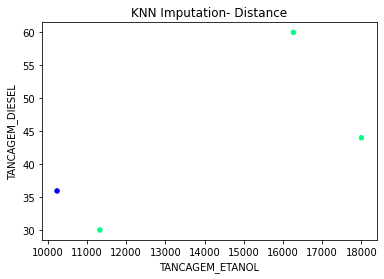

In [167]:
fig = plt.Figure()
null_values = imput['missingindicator_TANCAGEM_DIESEL']==0
fig = imput.plot(y='TANCAGEM_DIESEL', x='TANCAGEM_ETANOL', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation- Distance', colorbar=False)


StatementMeta(dssparkpool, 626, 186, Finished, Available)

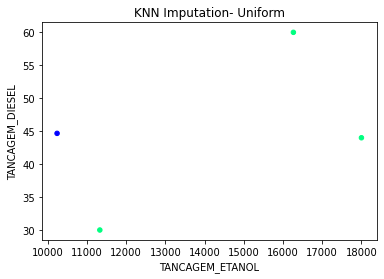

In [170]:
fig = plt.Figure()
null_values = imput['missingindicator_TANCAGEM_DIESEL']==0
fig = imput.plot(y='TANCAGEM_DIESEL', x='TANCAGEM_ETANOL', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation- Uniform', colorbar=False)

In [173]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=viz+1)
neigh.fit(imput[var])

StatementMeta(dssparkpool, 626, 189, Finished, Available)

NearestNeighbors(n_neighbors=4)

In [174]:
d, v = neigh.kneighbors([imput[var].loc[1].to_list()], return_distance=True)

StatementMeta(dssparkpool, 626, 190, Finished, Available)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa95bf008b0>
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/trusted-service-user/cluster-env/clonedenv/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/trusted-service-

In [175]:
n_imput.loc[list(v[0])]

StatementMeta(dssparkpool, 626, 191, Finished, Available)

,CNPJ,UF,REGIAO,CAP_HIDRATADO,CAP_ANIDRO,TANCAGEM_ETANOL,TANCAGEM_DIESEL,TIPO_IMP
1,05627254000158,RJ,SE,600.0,0.0,10240.0,NaN,0
3,28963189000137,RJ,SE,150.0,0.0,11330.0,30.0,0
0,05500757000168,RJ,SE,250.0,0.0,16265.0,60.0,0
2,28851889000210,RJ,SE,270.0,240.0,18000.0,44.0,0


In [176]:
imput.loc[list(v[0])]

StatementMeta(dssparkpool, 626, 192, Finished, Available)

,CNPJ,UF,REGIAO,TIPO_IMP,CAP_HIDRATADO,CAP_ANIDRO,TANCAGEM_ETANOL,TANCAGEM_DIESEL,missingindicator_TANCAGEM_DIESEL
1,05627254000158,RJ,SE,0,600.0,0.0,10240.0,44.666667,1.0
3,28963189000137,RJ,SE,0,150.0,0.0,11330.0,30.000000,0.0
0,05500757000168,RJ,SE,0,250.0,0.0,16265.0,60.000000,0.0
2,28851889000210,RJ,SE,0,270.0,240.0,18000.0,44.000000,0.0


In [182]:
n_imput.loc[list(v[0][1:])]['TANCAGEM_DIESEL'].mean()

StatementMeta(dssparkpool, 627, 2, Finished, Available)

NameError: name 'n_imput' is not defined

In [ ]:
(50+60+75)/3

StatementMeta(, , , Cancelled, )

In [ ]:
erro

In [ ]:
fig, axis = plt.subplots(2,2,figsize=(8, 8))
df.hist(ax=axis, bins=50)

StatementMeta(, , , Cancelled, )

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(2,2,figsize=(8, 8))
usinas_impt[var].hist(ax=axis, bins=50)

StatementMeta(, , , Cancelled, )

In [ ]:
usinas_impt[var].hist()

StatementMeta(, , , Cancelled, )

In [ ]:
df = usinas_impt[var]
knn = KNNImputer(n_neighbors=5, add_indicator=True)
knn.fit(df)
pd.DataFrame(knn.transform(df), columns=knn.get_feature_names_out())

StatementMeta(, , , Cancelled, )

In [ ]:
knn.

StatementMeta(, , , Cancelled, )

StatementMeta(, , , Cancelled, )

# ADD infos do Histórico de vendas da VIBRA

In [189]:
#del(col_names, col_types)                                                  # eliminando dados de outra leitura
col_names = pd.read_csv(abfss_path_raw + files[5], nrows=0).columns         # coletando informações de cabeçalho
col_types = {col: str for col in col_names if col not in {}}                # todas as colunas como str

hist = pd.read_csv(abfss_path_raw + files[5], dtype=col_types,
                        storage_options = {'linked_service' : linked_service_raw})

hist.drop('keymodel',axis=1,inplace=True) # var não necessária
hist['VEDI_VOL'] = hist['VEDI_VOL'].astype(float)
hist['VEDI_DAT_VEN'] = pd.to_datetime(hist['VEDI_DAT_VEN'])

#organizando o Coreto!
hist = hist[['CLIE_NUM_CPF_CNPJ', 'CLIE_NOM_CLIENTE','VEDI_COD_CLI', 'VEDI_VOL', 'VEDI_DAT_VEN', 'ProdutoD', 'AECO']]

hist.rename(columns={'CLIE_NUM_CPF_CNPJ': 'CNPJ'}, errors='raise', inplace=True)

StatementMeta(dssparkpool, 627, 17, Finished, Available)

In [190]:
hist

StatementMeta(dssparkpool, 627, 18, Finished, Available)

,CNPJ,CLIE_NOM_CLIENTE,VEDI_COD_CLI,VEDI_VOL,VEDI_DAT_VEN,ProdutoD,AECO
0,26300196000123,ARAUNA PETRO COMBUSTIVEIS LTDA,1165222,23492.800000,2022-06-17,Diesel,TRR
1,17890705000124,PETRODADO COMERCIO DE COMBUSTIVEIS,1021492,20341.450000,2022-02-24,Diesel,TRR
2,87356168000112,T R R COMBUSTIVEIS OURENSE LTDA,20991,19418.560151,2018-08-30,Diesel,TRR
3,13462206000185,SAVE REVENDEDOR RETALHISTA LTDA.,1045004,19107.780000,2022-03-04,Diesel,TRR
4,05787607000187,WELP TRANSPORTADOR REVENDEDOR RETAL,85310,18930.800000,2022-05-09,Diesel,TRR
...,...,...,...,...,...,...,...
40893,40254927000172,PARANA XISTO S.A.,1660529,-575.000000,2022-10-13,Diesel,ÓLEO E GÁS
40894,15144306000199,VALE MANGANES S.A,9585,-585.000000,2018-01-16,Diesel,METALURGIA E SIDERUR
40895,04028583000209,EQUINOR BRASIL ENERGIA LTDA.,148699,-800.000000,2021-09-08,Diesel,ÓLEO E GÁS
40896,33000167111957,PETROLEO BRASILEIRO S A PETROBRAS,35668,-995.000000,2022-08-19,Diesel,ÓLEO E GÁS


### Explorer histdiesel

In [191]:
import plotly.graph_objects as go

StatementMeta(dssparkpool, 627, 19, Finished, Available)

In [192]:
# multi_plot requires two variables:
# - df is a dataframe with stocks as columns and rows as date of the stock price
# - addAll is to have a dropdown button to display all stocks at once
def multi_plot(df, addAll = True):
    fig = go.Figure()

    for column in df.columns.to_list():
        fig.add_trace(
            go.Scatter(
                x = df.index,
                y = df[column],
                name = column
            )
        )

    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns.isin(df.columns),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns.isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = ([button_all] * addAll) + list(df.columns.map(lambda column: create_layout_button(column)))
            )
        ])
    
    fig.show()

StatementMeta(dssparkpool, 627, 20, Finished, Available)

In [193]:
def hist_geo(geo='UF'):
    aux = hist1.set_index('VEDI_DAT_VEN')
    aux = aux.groupby([geo]).resample('MS').sum()
    aux = aux.unstack(level=0)
    aux.columns = aux.columns.droplevel(0)
    aux = aux.rename_axis(None, axis=1)
    return(aux)

def hist_all():
    aux = hist1.set_index('VEDI_DAT_VEN')
    aux = aux.resample('MS').sum()
    return(aux)

StatementMeta(dssparkpool, 627, 21, Finished, Available)

In [198]:
# colentando cod nomes UFs
uf = pd.json_normalize(Estados().json_ibge)

hist1 = hist.merge(mm_proj[['CNPJ','UF']], how='left', on='CNPJ')                                   # Agregando UF ao Histórico
hist1 = hist1.merge(uf[['sigla','regiao.sigla']], how='left', left_on='UF', right_on='sigla')       # Agregando Região ao Histórico
hist1.rename(columns={'regiao.sigla':'REGIAO'}, inplace=True)
hist1.drop('sigla', axis=1, inplace=True)
hist1 = hist1[hist1['AECO']=='USINA'].reset_index(drop=True)


hist1.loc[hist1['UF'].isnull(),['UF','REGIAO']] = 'Sem_UF'


StatementMeta(dssparkpool, 627, 26, Finished, Available)

In [ ]:
multi_plot(hist_all())

StatementMeta(, , , Cancelled, )

In [ ]:
multi_plot(hist_geo('REGIAO'))

StatementMeta(, , , Cancelled, )

In [ ]:
multi_plot(hist_geo('UF'))


StatementMeta(, , , Cancelled, )

### Filtros da base de histórico de vendas Vibra

**Nota**

Estudar a natureza e peculiaridades das vendas AECO=USINA
GRAFICO VENDAS VIBRA USINAS NO TEMPO MES/ANO - groupbr mes/ano sum() VOL VENDAS

In [ ]:
#dfUsinaVibra[(dfUsinaVibra[ "VEDI_VOL" ] <=50) & (dfUsinaVibra['AECO']=='USINA')]

StatementMeta(, , , Cancelled, )

In [262]:
dfUsinaVibra = hist[(hist["ProdutoD"] == "Diesel") & (hist[ "VEDI_VOL" ] > 0)]      # eliminando dados de vendas negativas ou zeradas
dfUsinaVibra = dfUsinaVibra.merge(usinas1[['CNPJ', 'MUNICIPIO','UF', 'TANCAGEM_DIESEL', 'SITUACAO_ANP']], how='left', on ='CNPJ')
df = dfUsinaVibra.copy()

StatementMeta(dssparkpool, 627, 106, Finished, Available)

In [265]:
df[df['CLIE_NOM_CLIENTE']=='WD AGROINDUSTRIAL LTDA']

StatementMeta(dssparkpool, 627, 109, Finished, Available)

,CNPJ,CLIE_NOM_CLIENTE,VEDI_COD_CLI,VEDI_VOL,VEDI_DAT_VEN,ProdutoD,AECO,MUNICIPIO,UF,TANCAGEM_DIESEL,SITUACAO_ANP
3269,01105558000102,WD AGROINDUSTRIAL LTDA,64314,3749.1,2018-05-11,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
4029,01105558000102,WD AGROINDUSTRIAL LTDA,64314,3112.5,2019-06-19,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
4342,01105558000102,WD AGROINDUSTRIAL LTDA,64314,2961.0,2020-04-27,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
6078,01105558000102,WD AGROINDUSTRIAL LTDA,64314,2486.1,2021-07-30,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
9540,01105558000102,WD AGROINDUSTRIAL LTDA,64314,1850.5,2020-11-07,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
9567,01105558000102,WD AGROINDUSTRIAL LTDA,64314,1845.7,2022-06-21,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
13592,01105558000102,WD AGROINDUSTRIAL LTDA,64314,881.9,2022-03-22,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
13658,01105558000102,WD AGROINDUSTRIAL LTDA,64314,870.5,2017-12-02,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA


In [266]:
df[df['CNPJ'].isin(['00143381000168','01105558000102'])]

StatementMeta(dssparkpool, 627, 110, Finished, Available)

,CNPJ,CLIE_NOM_CLIENTE,VEDI_COD_CLI,VEDI_VOL,VEDI_DAT_VEN,ProdutoD,AECO,MUNICIPIO,UF,TANCAGEM_DIESEL,SITUACAO_ANP
3269,01105558000102,WD AGROINDUSTRIAL LTDA,64314,3749.100,2018-05-11,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
4029,01105558000102,WD AGROINDUSTRIAL LTDA,64314,3112.500,2019-06-19,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
4342,01105558000102,WD AGROINDUSTRIAL LTDA,64314,2961.000,2020-04-27,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
6078,01105558000102,WD AGROINDUSTRIAL LTDA,64314,2486.100,2021-07-30,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
9540,01105558000102,WD AGROINDUSTRIAL LTDA,64314,1850.500,2020-11-07,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
9567,01105558000102,WD AGROINDUSTRIAL LTDA,64314,1845.700,2022-06-21,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
12922,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,1032.500,2017-05-27,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA
13225,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,965.500,2016-05-03,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA
13592,01105558000102,WD AGROINDUSTRIAL LTDA,64314,881.900,2022-03-22,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA
13658,01105558000102,WD AGROINDUSTRIAL LTDA,64314,870.500,2017-12-02,Diesel,USINA,João Pinheiro,MG,165.0,ATIVA


In [ ]:
tupla = dfUsinaVibra[['UF','AECO']].values.tolist()

dfUsinaVibra['STATUS'] = [('AECO!=USINA e NÃO presente em MAPA+ANP' if pd.isnull(x) & (y!='USINA') else 
                            ('AECO==USINA e NÃO presente em MAPA+ANP' if pd.isnull(x) & (y=='USINA') else
                                ('AECO==USINA e presente MAPA+ANP' if ~pd.isnull(x) & (y=='USINA') else 'AECO!=USINA e presente MAPA+ANP'))) 
                                    for x, y in tupla]
del(tupla)

StatementMeta(, , , Cancelled, )

In [ ]:
dfUsinaVibra.sort_values(['CNPJ', 'VEDI_DAT_VEN'], inplace=True)
dfUsinaVibra.drop_duplicates('CNPJ', keep='last', inplace=True)
dfUsinaVibra.reset_index(drop=True, inplace=True)

StatementMeta(, , , Cancelled, )

In [ ]:
dfUsinaVibra['STATUS'].value_counts()

StatementMeta(, , , Cancelled, )

In [ ]:
# Salvando para o sergio
# dfUsinaVibra.to_csv(abfss_path_raw +'relatorio.csv')

StatementMeta(, , , Cancelled, )

### Imputação em Vendas por Ano

**NOTA**

CONSIDERANDO AS USINAS (MAPA+ANP) DE HOJE

In [258]:
df = df[~df['UF'].isna()].sort_values(['CNPJ','VEDI_DAT_VEN']).reset_index(drop=True)       # Filtro somente dos CNPJ presentes em MAPA+ANP
df['ANO'] = df['VEDI_DAT_VEN'].dt.strftime('%Y')                                            # Incluindo variável ANO
        

StatementMeta(dssparkpool, 627, 102, Finished, Available)

In [261]:
df[df['CNPJ']=='00143381000168']

StatementMeta(dssparkpool, 627, 105, Finished, Available)

,CNPJ,CLIE_NOM_CLIENTE,VEDI_COD_CLI,VEDI_VOL,VEDI_DAT_VEN,ProdutoD,AECO,MUNICIPIO,UF,TANCAGEM_DIESEL,SITUACAO_ANP,ANO
0,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,491.000,2016-04-25,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2016
1,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,965.500,2016-05-03,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2016
2,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,414.500,2017-02-20,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2017
3,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,1032.500,2017-05-27,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2017
4,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,289.500,2018-06-23,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2018
5,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,555.000,2019-04-01,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2019
6,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,92671,517.195,2019-06-27,Diesel,OUTROS,Ponta Porã,MS,135.0,REVOGADA,2019


In [259]:
# agrupando as vendas por cnpj e ano trazendo volume médio, numero de vendas e volume total de DIESEL
df_g = df.groupby(['CNPJ','CLIE_NOM_CLIENTE','ANO'])['VEDI_VOL'].agg(Vol_Total = 'sum', Freq='count', Vol_Medio='mean').reset_index()

StatementMeta(dssparkpool, 627, 103, Finished, Available)

In [260]:
df_g

StatementMeta(dssparkpool, 627, 104, Finished, Available)

,CNPJ,CLIE_NOM_CLIENTE,ANO,Vol_Total,Freq,Vol_Medio
0,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,2016,1456.50000,2,728.250000
1,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,2017,1447.00000,2,723.500000
2,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,2018,289.50000,1,289.500000
3,00143381000168,MONTEVERDE AGRO-ENERGETICA S.A,2019,1072.19500,2,536.097500
4,01105558000102,WD AGROINDUSTRIAL LTDA,2017,870.50000,1,870.500000
...,...,...,...,...,...,...
638,75717355001177,USINA DE ACUCAR SANTA TEREZINHA LTD,2019,10962.50000,6,1827.083333
639,75717355001177,USINA DE ACUCAR SANTA TEREZINHA LTD,2020,5325.40000,3,1775.133333
640,75717355001177,USINA DE ACUCAR SANTA TEREZINHA LTD,2021,8317.40000,4,2079.350000
641,75717355001177,USINA DE ACUCAR SANTA TEREZINHA LTD,2022,2015.00000,1,2015.000000


In [ ]:
cols = ['CNPJ','UF','REGIAO','ANO','CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL','TANCAGEM_DIESEL', 'Vol_Total','Freq','Vol_Medio']
var  = ['CAP_HIDRATADO','CAP_ANIDRO','TANCAGEM_ETANOL','TANCAGEM_DIESEL','Vol_Total','Freq','Vol_Medio']

anos = sorted(df_g['ANO'].value_counts().index.tolist())
result =pd.DataFrame()

print('Participação anual VIBRA no Mercado de USINAS')
for i in anos[:-1]:                                     # até o ultimo ano completo
    df_a = df_g[df_g["ANO"]==i][['CNPJ','ANO','Vol_Total','Freq','Vol_Medio']]
    us = usinas.merge(df_a, how='left', on='CNPJ')
    us["ANO"]=i
    print('{}: {:2.2%}'.format(i, us[~us['Freq'].isnull()].shape[0]/len(us)))
    aux = agrega_imputados(us[cols], var, chave='CNPJ', alvo='Vol_Medio', nivel=['UF', 'REGIAO'], viz=5)
    result = pd.concat([result, aux], axis=0, ignore_index=True)

StatementMeta(, , , Cancelled, )

In [ ]:
result

StatementMeta(, , , Cancelled, )

In [ ]:
result[(result['TIPO_IMP']==0)&(result['ANO']=='2022')]

StatementMeta(, , , Cancelled, )

In [ ]:
result[result['CNPJ']=='00143381000168']

StatementMeta(, , , Cancelled, )

In [ ]:
df_g[df_g['CNPJ']=='00143381000168']

StatementMeta(, , , Cancelled, )

### Métrica das imputações em relação ao uma participação de 20% de mercado de Usinas na vibra 

In [ ]:
for i in anos[:-1]:
    x = df_g[df_g['ANO']==i]['Vol_Total'].sum()
    print(i,': ', x,'| projeção:', x*5)

StatementMeta(, , , Cancelled, )

In [ ]:
for i in anos[:-1]:
    x = result[result['ANO']==i]['Vol_Total'].sum()
    print(i,': ', x)

StatementMeta(, , , Cancelled, )